In [1]:
pip install -q "tensorflow-text==2.8.*"

Note: you may need to restart the kernel to use updated packages.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [12]:
!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt

--2022-04-23 13:51:12--  https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
Resolving www.cs.mtsu.edu (www.cs.mtsu.edu)... 161.45.162.100
Connecting to www.cs.mtsu.edu (www.cs.mtsu.edu)|161.45.162.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683838 (668K) [text/plain]
Saving to: ‘PandP_Jane_Austen.txt.1’

PandP_Jane_Austen.t 100%[===================>] 667.81K  --.-KB/s    in 0.008s  

2022-04-23 13:51:12 (86.0 MB/s) - ‘PandP_Jane_Austen.txt.1’ saved [683838/683838]



In [13]:
# Preprocessing - grab lines from the file
with open('PandP_Jane_Austen.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# Paragraphs are separated by blank
# lines -> just drop those lines...
text = []
for i in range(len(lines)):
     if lines[i] != '':
        text = text + [lines[i]]
data = np.vstack([[text[0:-1]],[text[1:]]]).T
data.shape

(10657, 2)

In [14]:
# Subset? - All of the data will take some time...
n_seq = 100
split_point = 80
data = data[0:n_seq]
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop
max_length

74

In [15]:
def encode_seq(x,mapping,max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
def decode_seq(x,mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [16]:
i_to_c_pandp = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_pandp = {i_to_c_pandp[i]:i for i in range(len(i_to_c_pandp))}
i_to_c_pandp[1] = i_to_c_pandp[2] = ''

In [17]:
X = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x,c_to_i_pandp,max_length) for x in data[:,1]])

In [18]:
x_train = X[:split_point]
x_test = X[split_point:]
pre_y_train = Y[:,0:-1][:split_point]
pre_y_test = Y[:,0:-1][split_point:]
post_y_train = Y[:,1:][:split_point]
post_y_test = Y[:,1:][split_point:]

In [19]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, dropout):
        super(Transformer_Block, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.feed_forward = keras.Sequential([keras.layers.Dense(ff_dim, activation = "gelu"), keras.layers.Dense(embed_dim)])
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(dropout)
        self.dropout2 = keras.layers.Dropout(dropout)
        
    def call(self, embedded_words, training):
        attention_output = self.attention(embedded_words, embedded_words)
        attention_output = self.dropout1(attention_output, training=training)
        #Residual connections from input to add/norm
        res1 = self.layer_norm1(embedded_words + attention_output)
        ffn_output = self.feed_forward(res1)
        ffn_output = self.dropout2(ffn_output, training=training)
        #Residual connections from add/norm to add/norm
        final_output = self.layer_norm2(ffn_output + res1)
        return final_output

In [20]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [21]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [22]:
#Pool encoder output with existing context matrix
class Multi_Head_Attention_Pooling(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, dropout):
        super(Multi_Head_Attention_Pooling, self).__init__()
        self.attention = keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        
    #Pass in encoder as input[0], context matrix as input[1]
    def call(self, input_data):
        attention_output = self.attention(input_data[0], input_data[1])
        self_attention_output = self.attention(attention_output, attention_output)
        pooled_context = self_attention_output
        return pooled_context

In [23]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)

In [25]:
#Variables
embed_dim = 512
#data = input_sequences
training = True
#total_words = total_words
#max_sentence_length = max_sentence_length
num_heads = 8 
ff_dim = 16
dropout = 0.15
num_seeds = 32

encoder_stack = 1
decoder_stack = 1

#Initialize context matrix
context = tf.random.uniform(shape=(1, num_seeds, embed_dim))

2022-04-23 13:51:26.852275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-23 13:51:26.852378: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 13:51:26.852443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-klg6z): /proc/driver/nvidia/version does not exist
2022-04-23 13:51:26.854065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


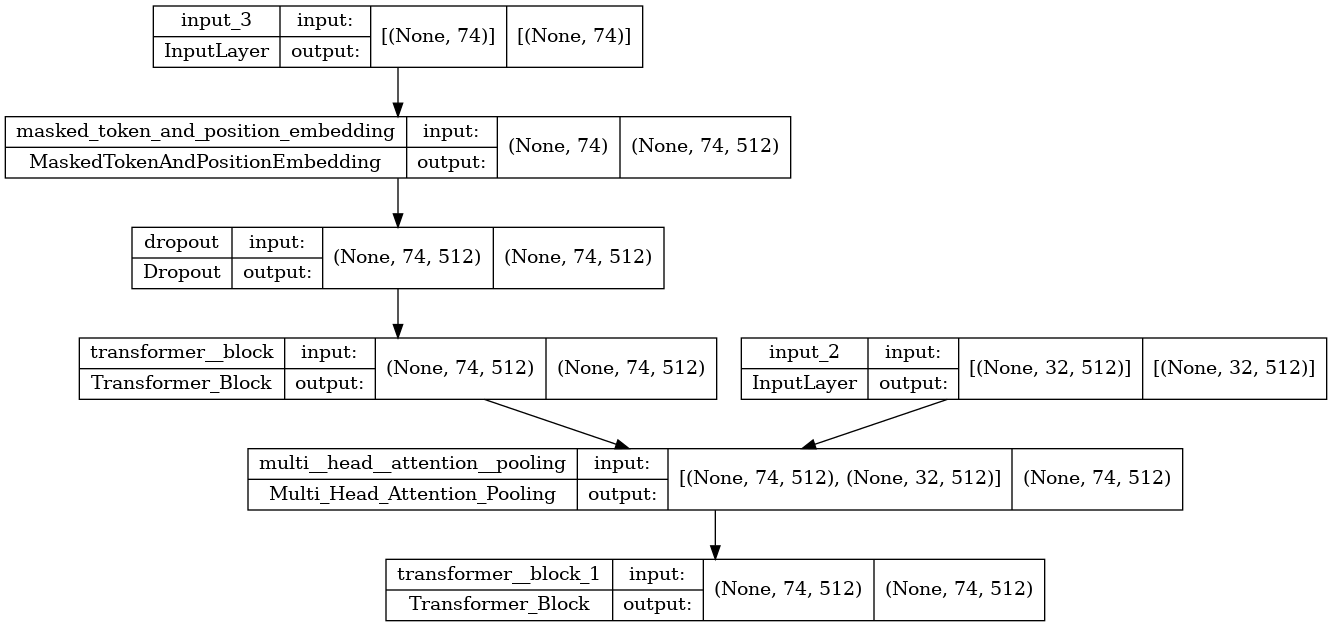

In [28]:
#Encoder

#Create layer for context
context_input_layer_encoder = keras.layers.Input(shape=context.shape[1:])

#Sequence input
input_layer = keras.layers.Input(shape=x_train.shape[1:])
position_embedding_layer =  MaskedTokenAndPositionEmbedding(x_train.shape[1], len(c_to_i_pandp), embed_dim)(input_layer)

#Dropout
dropout = keras.layers.Dropout(dropout,noise_shape=position_embedding_layer.shape[:-1]+(1,))(position_embedding_layer)
encoder = dropout

for i in range(encoder_stack):
    encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(encoder)

input_context_pooling_layer = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([encoder, context_input_layer_encoder])
                                                                                                  
encoder = Transformer_Block(num_heads, embed_dim, ff_dim, dropout)(input_context_pooling_layer)

encoder_model = keras.Model([input_layer, context_input_layer_encoder], encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

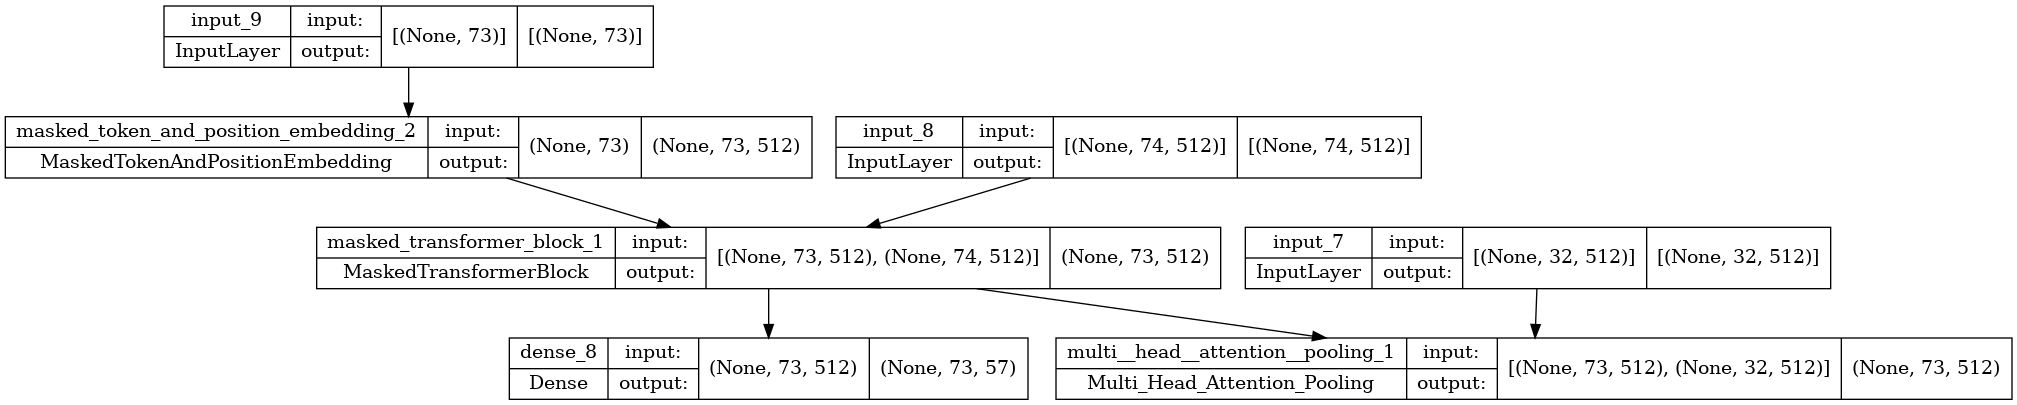

In [30]:
#Decoder 

#Context input_layer
context_input_layer_decoder = keras.layers.Input(shape=context.shape[1:])

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = pre_y_train.shape[1:])
position_embedding_layer = MaskedTokenAndPositionEmbedding(pre_y_train.shape[1], len(c_to_i_pandp), embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(len(i_to_c_pandp))(decoder)

#Output of decoder/linear layer? should go to update context matrix with pooling
context = Multi_Head_Attention_Pooling(num_heads, embed_dim, dropout)([decoder, context_input_layer_decoder])

decoder_model = keras.Model([input_layer, encoder_input_layer, context_input_layer_decoder], [linear_layer, context])
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

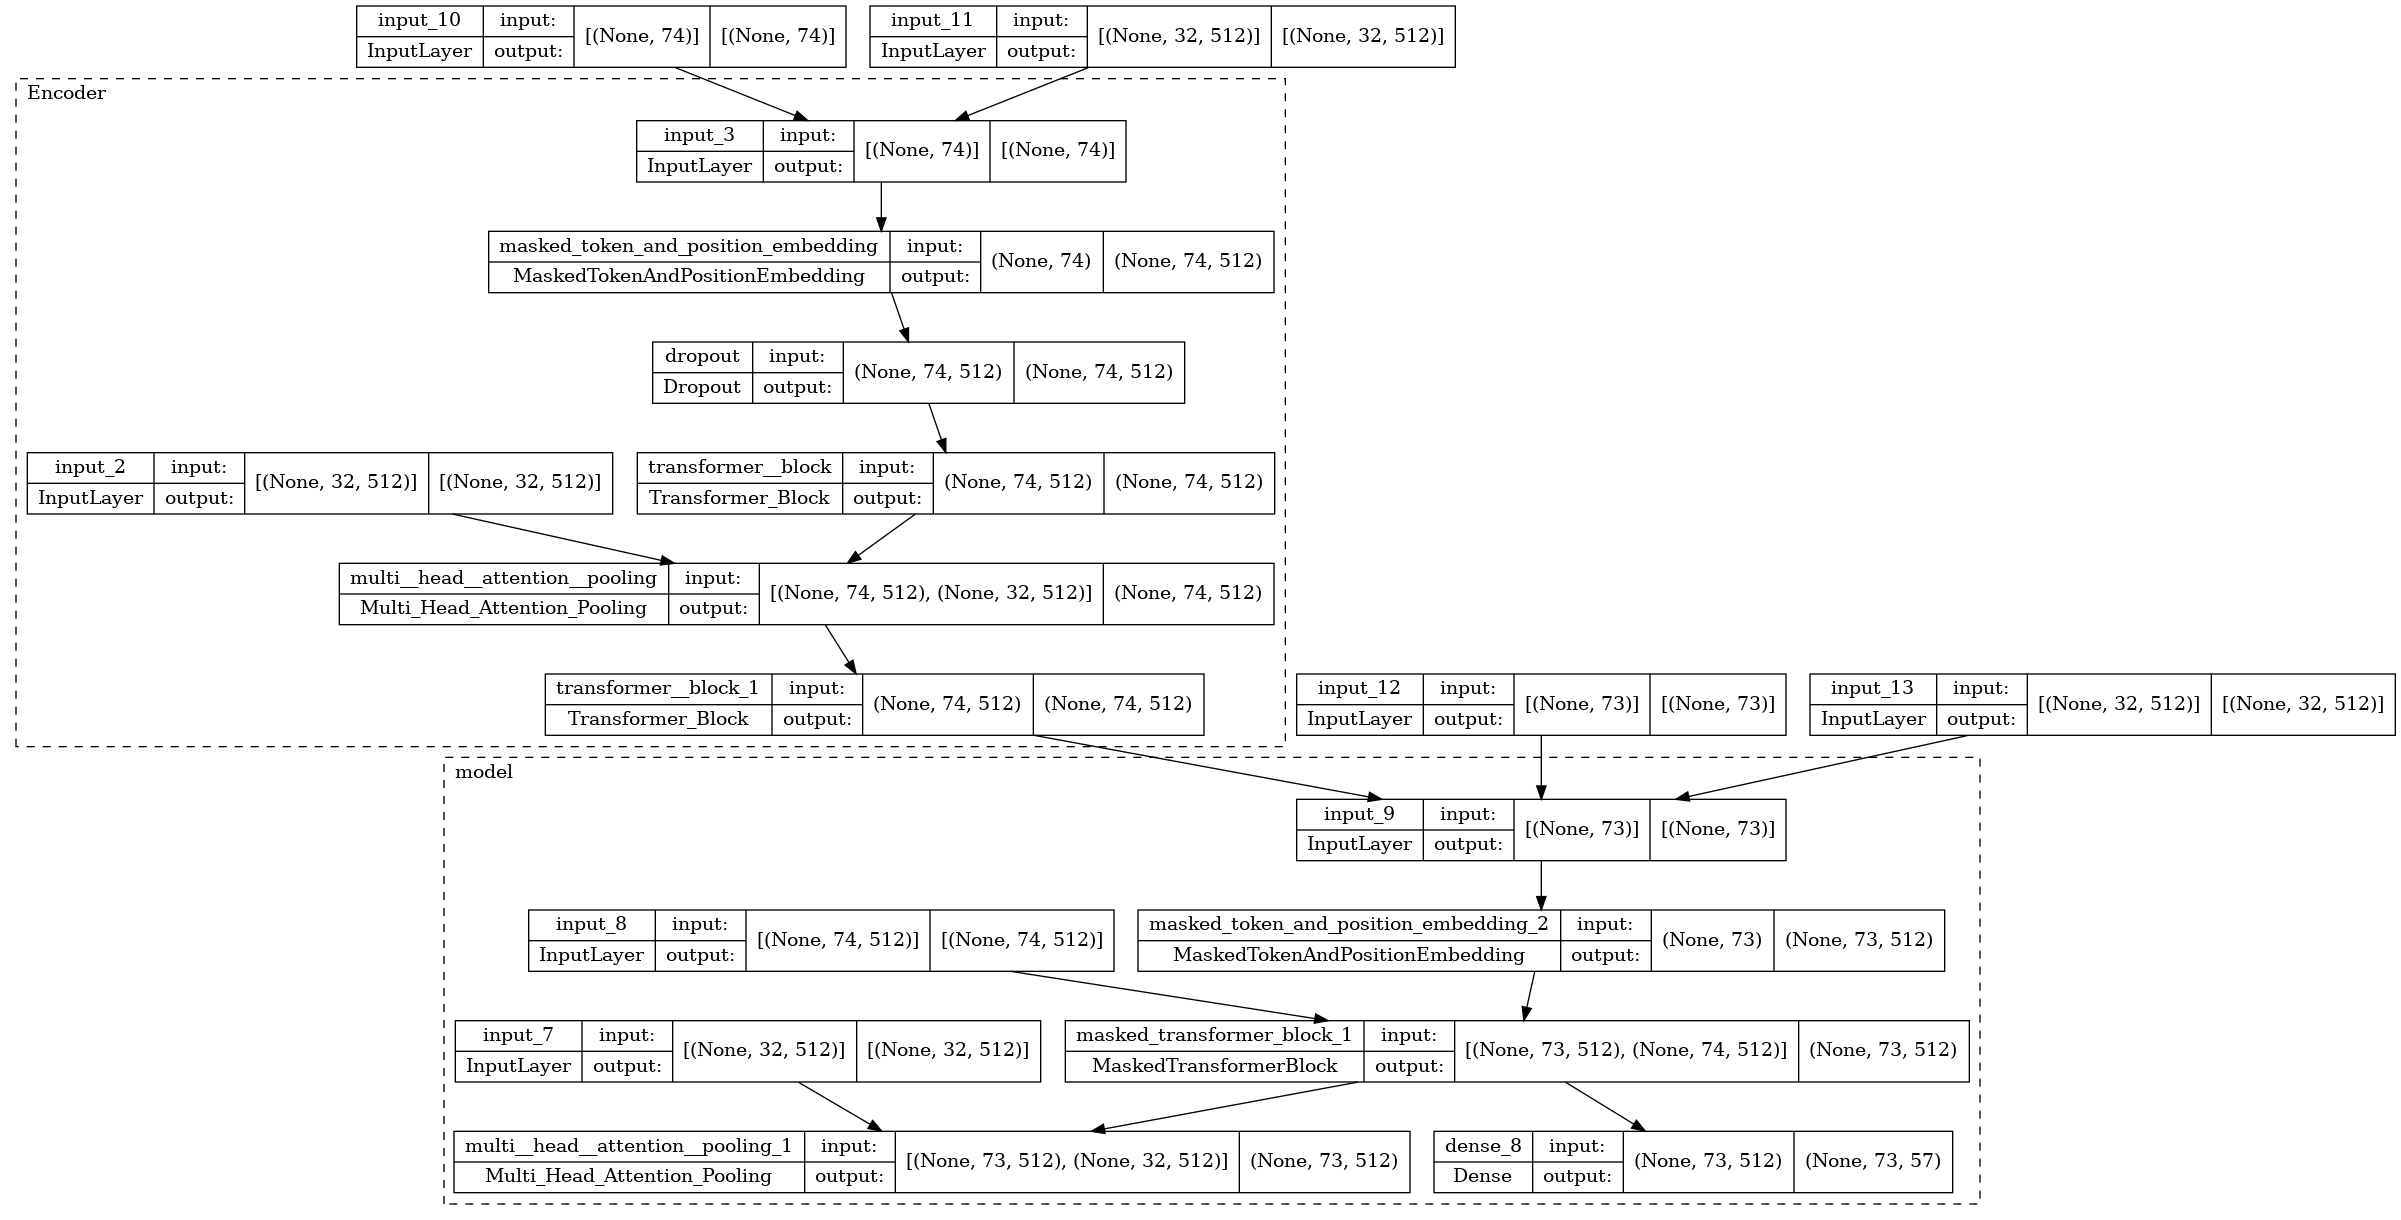

In [31]:
sequences = keras.layers.Input(encoder_model.input_shape[0][1:])
context = keras.layers.Input(encoder_model.input_shape[1][1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])
context_decoder = keras.layers.Input(decoder_model.input_shape[2][1:])



transformer = decoder_model([targets, encoder_model([sequences, context]), context_decoder])
transformer = keras.Model([sequences, context_decoder, targets, context], transformer)


keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [37]:
transformer.compile(loss=MaskedSparseCategoricalCrossentropy, optimizer=keras.optimizers.Adam(), metrics=[MaskedSparseCategoricalAccuracy])

transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 74)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 32, 512)]    0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 73)]         0           []                               
                                                                                                  
 Encoder (Functional)           (None, 74, 512)      25309728    ['input_10[0][0]',               
                                                                  'input_11[0][0]']         

In [46]:
#transformer = keras.Model([sequences, context_decoder, targets, context], transformer)

batch_size = 20 # needs to be reasonable due to activation/delta storage...
epochs = 150
history = transformer.fit([x_train, context_decoder, pre_y_train, context], [post_y_train, context_decoder], batch_size=batch_size, epochs=epochs,  validation_data=([x_test,pre_y_test], post_y_test), verbose=0)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
print('Training Accuracy:',coupled.evaluate([x_train,pre_y_train],post_y_train)[1]*100.0,'%')
print('Validation Accuracy:',coupled.evaluate([x_test,pre_y_test],post_y_test)[1]*100.0,'%')

In [ ]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['MaskedSparseCategoricalAccuracy'])
plt.plot(history.history['val_MaskedSparseCategoricalAccuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='upper right') 

In [ ]:
# Iterate - teacher forcing through each line
result = transformer.predict([x_train,pre_y_train]).argmax(-1)
for i in range(0,len(x_train)):
    # Teacher-forcing
    print('---')
    print('Txt:',decode_seq(post_y_train[i],i_to_c_pandp))
    print('Net:',decode_seq(result[i],i_to_c_pandp))

In [ ]:
# Iterate - but -NO- teacher forcing through each line
context = encoder_model.predict(x_train)
token = np.zeros(pre_y_train.shape)
token[:,0] = 1 # Just a start token
for x in range(post_y_train.shape[1]-1):
    result = decoder_model.predict([token,context]).argmax(-1)
    token[:,x+1] = result[:,x]
result = decoder_model.predict([token,context]).argmax(-1)
for i in range(0,len(x_train)):
    print('---')
    print('Txt:',decode_seq(post_y_train[i],i_to_c_pandp))
    print('Net:',decode_seq(result[i],i_to_c_pandp))